In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [340]:
import h5py
import pickle
import numpy as np
import torch
import torch_interpolations as torchitp
from torchquad import Simpson, set_up_backend
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import quad
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect
import time

import ring_network as network
import sim_util as su
import ricciardi as ric
import integrate as integ

def imshowbar(fig,ax,A,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imsh, cax=cax, orientation='vertical')
    
def ytitle(ax,text,xloc=-0.25,**kwargs):
    ax.text(xloc,0.5,text,horizontalalignment='left',verticalalignment='center',
        rotation='vertical',transform=ax.transAxes,**kwargs)

# Read itp.h5, Interpolate Base Moments

In [161]:
def μtox(μ):
    return np.sign(μ/100-0.2)*np.abs(μ/100-0.2)**0.5

def xtoμ(x):
    return 100*(np.sign(x)*np.abs(x)**2.0+0.2)

def extract_itp(file):
    f = h5py.File(file, 'r')
    
    φxrange = list(f['PhItp']['xrange'])
    φxs = np.linspace(φxrange[0],φxrange[1],round(φxrange[2]))
    φEs = np.array(f['PhItp']['rp1']['Phs'])
    φIs = np.array(f['PhItp']['rp2']['Phs'])
    
    Mxrange = list(f['MItp']['xrange'])
    Mxs = np.linspace(Mxrange[0],Mxrange[1],round(Mxrange[2]))
    Mσrange = list(f['MItp']['srange'])
    Mσs = np.linspace(Mσrange[0],Mσrange[1],round(Mσrange[2]))
    MEs = np.array(f['MItp']['rp1']['Ms'])
    MIs = np.array(f['MItp']['rp2']['Ms'])
    
    Cxrange = list(f['CItp']['xrange'])
    Cxs = np.linspace(Cxrange[0],Cxrange[1],round(Cxrange[2]))
    Cσrange = list(f['CItp']['srange'])
    Cσs = np.linspace(Cσrange[0],Cσrange[1],round(Cσrange[2]))
    Ccrange = list(f['CItp']['crange'])
    Ccs = np.linspace(Ccrange[0],Ccrange[1],round(Ccrange[2]))
    CEs = np.array(f['CItp']['rp1']['Cs'])
    CIs = np.array(f['CItp']['rp2']['Cs'])
    
    φE_itp = RegularGridInterpolator((φxs,),φEs,bounds_error=False,fill_value=None)
    φI_itp = RegularGridInterpolator((φxs,),φIs,bounds_error=False,fill_value=None)
    
    ME_itp = RegularGridInterpolator((Mσs,Mxs),MEs,bounds_error=False,fill_value=None)
    MI_itp = RegularGridInterpolator((Mσs,Mxs),MIs,bounds_error=False,fill_value=None)
    
    CE_itp = RegularGridInterpolator((Ccs,Cσs,Cxs),CEs,bounds_error=False,fill_value=None)
    CI_itp = RegularGridInterpolator((Ccs,Cσs,Cxs),CIs,bounds_error=False,fill_value=None)
    
    base_itp_dict = {}
    base_itp_dict['φE_itp'] = φE_itp
    base_itp_dict['φI_itp'] = φI_itp
    base_itp_dict['ME_itp'] = ME_itp
    base_itp_dict['MI_itp'] = MI_itp
    base_itp_dict['CE_itp'] = CE_itp
    base_itp_dict['CI_itp'] = CI_itp
    
    with open('base_itp'+'.pkl', 'wb') as handle:
        pickle.dump(base_itp_dict,handle)
    
    def φE(μ):
        try:
            return φE_itp(μtox(1e3*μ)[:,None])
        except:
            return φE_itp([μtox(1e3*μ)])
    def φI(μ):
        try:
            return φI_itp(μtox(1e3*μ)[:,None])
        except:
            return φI_itp([μtox(1e3*μ)])
    
    def ME(μ,Σ):
        return ME_itp(np.row_stack(list(np.broadcast(1e3*np.sqrt(Σ),μtox(1e3*μ)))))
    def MI(μ,Σ):
        return MI_itp(np.row_stack(list(np.broadcast(1e3*np.sqrt(Σ),μtox(1e3*μ)))))
    
    def CE(μ,Σ,k):
        c = np.sign(k)*np.fmin(np.abs(k)/Σ,1)
        return CE_itp(np.row_stack(list(np.broadcast(c,1e3*np.sqrt(Σ),μtox(1e3*μ)))))
    def CI(μ,Σ,k):
        c = np.sign(k)*np.fmin(np.abs(k)/Σ,1)
        return CI_itp(np.row_stack(list(np.broadcast(c,1e3*np.sqrt(Σ),μtox(1e3*μ)))))
    
    return φE,φI,ME,MI,CE,CI

In [162]:
φE,φI,ME,MI,CE,CI = extract_itp('itp.h5')

# Define Base Ring DMFT Functions

In [354]:
def calc_M(μi,Σii,out):
    out[0] = ME(μi[0],Σii[0])[0]
    out[1] = MI(μi[1],Σii[1])[0]

def calc_C(μi,Σii,Σij,out):
    out[0] = CE(μi[0],Σii[0],Σij[0])[0]
    out[1] = CI(μi[1],Σii[1],Σij[1])[0]

def sparse_dmft(τ,W,K,Hb,Hp,εH,sW,sH,sa,Twrm,Tsav,dt,rb0=None,ra0=None,rp0=None,Crb0=None,Cra0=None,Crp0=None):
    Ntyp = len(Hb)
    Nint = round((Twrm+Tsav)/dt)+1
    Nclc = round(1.5*Tsav/dt)+1
    Nsav = round(Tsav/dt)+1
    
    rb = np.zeros((Ntyp,Nint),dtype=np.float32)
    ra = np.zeros((Ntyp,Nint),dtype=np.float32)
    rp = np.zeros((Ntyp,Nint),dtype=np.float32)
    Crb = np.zeros((Ntyp,Nint,Nint),dtype=np.float32)
    Cra = np.zeros((Ntyp,Nint,Nint),dtype=np.float32)
    Crp = np.zeros((Ntyp,Nint,Nint),dtype=np.float32)
    
    if rb0 is None:
        rb0 = 1e-8*np.ones((Ntyp),dtype=np.float32)
    if ra0 is None:
        ra0 = 2e-8*np.ones((Ntyp),dtype=np.float32)
    if rp0 is None:
        rp0 = 5e-8*np.ones((Ntyp),dtype=np.float32)
    if Crb0 is None:
        Crb0 = 1e2*np.ones((Ntyp,1),dtype=np.float32)
    if Cra0 is None:
        Cra0 = 4e2*np.ones((Ntyp,1),dtype=np.float32)
    if Crp0 is None:
        Crp0 = 25e2*np.ones((Ntyp,1),dtype=np.float32)
        
    τinv = 1/τ
    dtτinv = dt/τ
    dtτinv2 = dtτinv**2
    
    sa2 = sa**2
    sW2 = sW**2
    sH2 = sH**2
        
    μW = τ[:,None]*W*K
    ΣW = τ[:,None]**2*W**2*K
    
    μHb = τ*Hb
    ΣHb = (μHb*εH)**2
    μHa = τ*(Hb+(Hp-Hb)*np.exp(-0.5*sa2/sH2))
    ΣHa = (μHa*εH)**2
    μHp = τ*Hp
    ΣHp = (μHp*εH)**2
    
    rb[:,0] = rb0
    ra[:,0] = ra0
    rp[:,0] = rp0
    
    NCr0 = Crb0.shape[1]
    if Nclc > NCr0:
        Crb[:,0,:NCr0] = Crb0
        Crb[:,0,NCr0:Nclc] = Crb0[:,-1:]
        Crb[:,:NCr0,0] = Crb0
        Crb[:,NCr0:Nclc,0] = Crb0[:,-1:]
        
        Cra[:,0,:NCr0] = Cra0
        Cra[:,0,NCr0:Nclc] = Cra0[:,-1:]
        Cra[:,:NCr0,0] = Cra0
        Cra[:,NCr0:Nclc,0] = Cra0[:,-1:]
        
        Crp[:,0,:NCr0] = Crp0
        Crp[:,0,NCr0:Nclc] = Crp0[:,-1:]
        Crp[:,:NCr0,0] = Crp0
        Crp[:,NCr0:Nclc,0] = Crp0[:,-1:]
    else:
        Crb[:,0,:Nclc] = Crb0[:,:Nclc]
        Crb[:,:Nclc,0] = Crb0[:,:Nclc]
        
        Cra[:,0,:Nclc] = Cra0[:,:Nclc]
        Cra[:,:Nclc,0] = Cra0[:,:Nclc]
        
        Crp[:,0,:Nclc] = Crp0[:,:Nclc]
        Crp[:,:Nclc,0] = Crp0[:,:Nclc]
        
    Mφb = np.empty((Ntyp),dtype=np.float32)
    Mφa = np.empty((Ntyp),dtype=np.float32)
    Mφp = np.empty((Ntyp),dtype=np.float32)
    Cφb = np.empty((Ntyp),dtype=np.float32)
    Cφa = np.empty((Ntyp),dtype=np.float32)
    Cφp = np.empty((Ntyp),dtype=np.float32)
    
    for i in range(Nint-1):
        rbi = rb[:,i]
        rai = ra[:,i]
        rpi = rp[:,i]
        sr2i = 0.5*sa2/np.log(np.fmax(np.abs((rpi-rbi)/(rai-rbi)),1+1e-4))
        sWr2i = sW2+sr2i
        Crbii = Crb[:,i,i]
        Craii = Cra[:,i,i]
        Crpii = Crp[:,i,i]
        sCr2ii = 0.5*sa2/np.log(np.fmax(np.abs((Crpii-Crbii)/(Craii-Crbii)),1+1e-4))
        sWCr2ii = sW2+sCr2ii
        μbi = μW@rbi + μHb
        μai = ((1-np.sqrt(sr2i/sWr2i)*np.exp(-0.5*sa2/sWr2i))*μW)@rbi +\
            (np.sqrt(sr2i/sWr2i)*np.exp(-0.5*sa2/sWr2i)*μW)@rpi + μHa
        μpi = ((1-np.sqrt(sr2i/sWr2i))*μW)@rbi + (np.sqrt(sr2i/sWr2i)*μW)@rpi + μHp
        Σbii = ΣW@Crbii + ΣHb
        Σaii = ((1-np.sqrt(sCr2ii/sWCr2ii)*np.exp(-0.5*sa2/sWCr2ii))*ΣW)@Crbii +\
            (np.sqrt(sCr2ii/sWCr2ii)*np.exp(-0.5*sa2/sWCr2ii)*ΣW)@Crpii + ΣHa
        Σpii = ((1-np.sqrt(sCr2ii/sWCr2ii))*ΣW)@Crbii + (np.sqrt(sCr2ii/sWCr2ii)*ΣW)@Crpii + ΣHp
        calc_M(μbi,Σbii,Mφb)
        calc_M(μai,Σaii,Mφa)
        calc_M(μpi,Σpii,Mφp)
        kb1 = τinv*(-rbi + Mφb)
        ka1 = τinv*(-rai + Mφa)
        kp1 = τinv*(-rpi + Mφp)
        
        rbi = rb[:,i] + 0.5*dt*kb1
        rai = ra[:,i] + 0.5*dt*ka1
        rpi = rp[:,i] + 0.5*dt*kp1
        sr2i = 0.5*sa2/np.log(np.fmax(np.abs((rpi-rbi)/(rai-rbi)),1+1e-4))
        sWr2i = sW2+sr2i
        μbi = μW@rbi + μHb
        μai = ((1-np.sqrt(sr2i/sWr2i)*np.exp(-0.5*sa2/sWr2i))*μW)@rbi +\
            (np.sqrt(sr2i/sWr2i)*np.exp(-0.5*sa2/sWr2i)*μW)@rpi + μHa
        μpi = ((1-np.sqrt(sr2i/sWr2i))*μW)@rbi + (np.sqrt(sr2i/sWr2i)*μW)@rpi + μHp
        calc_M(μbi,Σbii,Mφb)
        calc_M(μai,Σaii,Mφa)
        calc_M(μpi,Σpii,Mφp)
        kb2 = τinv*(-rbi + Mφb)
        ka2 = τinv*(-rai + Mφa)
        kp2 = τinv*(-rpi + Mφp)
        
        rbi = rb[:,i] + 0.5*dt*kb2
        rai = ra[:,i] + 0.5*dt*ka2
        rpi = rp[:,i] + 0.5*dt*kp2
        sr2i = 0.5*sa2/np.log(np.fmax(np.abs((rpi-rbi)/(rai-rbi)),1+1e-4))
        sWr2i = sW2+sr2i
        μbi = μW@rbi + μHb
        μai = ((1-np.sqrt(sr2i/sWr2i)*np.exp(-0.5*sa2/sWr2i))*μW)@rbi +\
            (np.sqrt(sr2i/sWr2i)*np.exp(-0.5*sa2/sWr2i)*μW)@rpi + μHa
        μpi = ((1-np.sqrt(sr2i/sWr2i))*μW)@rbi + (np.sqrt(sr2i/sWr2i)*μW)@rpi + μHp
        calc_M(μbi,Σbii,Mφb)
        calc_M(μai,Σaii,Mφa)
        calc_M(μpi,Σpii,Mφp)
        kb3 = τinv*(-rbi + Mφb)
        ka3 = τinv*(-rai + Mφa)
        kp3 = τinv*(-rpi + Mφp)
        
        rbi = rb[:,i] + dt*kb3
        rai = ra[:,i] + dt*ka3
        rpi = rp[:,i] + dt*kp3
        sr2i = 0.5*sa2/np.log(np.fmax(np.abs((rpi-rbi)/(rai-rbi)),1+1e-4))
        sWr2i = sW2+sr2i
        μbi = μW@rbi + μHb
        μai = ((1-np.sqrt(sr2i/sWr2i)*np.exp(-0.5*sa2/sWr2i))*μW)@rbi +\
            (np.sqrt(sr2i/sWr2i)*np.exp(-0.5*sa2/sWr2i)*μW)@rpi + μHa
        μpi = ((1-np.sqrt(sr2i/sWr2i))*μW)@rbi + (np.sqrt(sr2i/sWr2i)*μW)@rpi + μHp
        calc_M(μbi,Σbii,Mφb)
        calc_M(μai,Σaii,Mφa)
        calc_M(μpi,Σpii,Mφp)
        kb4 = τinv*(-rbi + Mφb)
        ka4 = τinv*(-rai + Mφa)
        kp4 = τinv*(-rpi + Mφp)
        
        rb[:,i+1] = rb[:,i] + dt/6*(kb1+2*kb2+2*kb3+kb4)
        ra[:,i+1] = ra[:,i] + dt/6*(ka1+2*ka2+2*ka3+ka4)
        rp[:,i+1] = rp[:,i] + dt/6*(kp1+2*kp2+2*kp3+kp4)
        rbi = rb[:,i]
        rai = ra[:,i]
        rpi = rp[:,i]
        sr2i = 0.5*sa2/np.log(np.fmax(np.abs((rpi-rbi)/(rai-rbi)),1+1e-4))
        sWr2i = sW2+sr2i
        μbi = μW@rbi + μHb
        μai = ((1-np.sqrt(sr2i/sWr2i)*np.exp(-0.5*sa2/sWr2i))*μW)@rbi +\
            (np.sqrt(sr2i/sWr2i)*np.exp(-0.5*sa2/sWr2i)*μW)@rpi + μHa
        μpi = ((1-np.sqrt(sr2i/sWr2i))*μW)@rbi + (np.sqrt(sr2i/sWr2i)*μW)@rpi + μHp
        
        if np.any(np.abs(rb[:,i+1]) > 1e10) or np.any(np.isnan(rb[:,i+1])):
            print("system diverged when integrating rb")
            return rb,ra,rp,Crb,Cra,Crp,False
        if np.any(np.abs(ra[:,i+1]) > 1e10) or np.any(np.isnan(ra[:,i+1])):
            print("system diverged when integrating ra")
            return rb,ra,rp,Crb,Cra,Crp,False
        if np.any(np.abs(rp[:,i+1]) > 1e10) or np.any(np.isnan(rp[:,i+1])):
            print("system diverged when integrating rp")
            return rb,ra,rp,Crb,Cra,Crp,False

        if i > Nclc-1:
            Crb[:,i+1,i-Nclc] = Crb[:,i,i-Nclc]
            Cra[:,i+1,i-Nclc] = Cra[:,i,i-Nclc]
            Crp[:,i+1,i-Nclc] = Crp[:,i,i-Nclc]
            
        for j in range(max(0,i-Nclc),i+1):
            Crbij = Crb[:,i,j]
            Craij = Cra[:,i,j]
            Crpij = Crp[:,i,j]
            sCr2ij = 0.5*sa2/np.log(np.fmax(np.abs((Crpij-Crbij)/(Craij-Crbij)),1+1e-4))
            sWCr2ij = sW2+sCr2ij
            Σbij = ΣW@Crbij + ΣHb
            Σaij = ((1-np.sqrt(sCr2ij/sWCr2ij)*np.exp(-0.5*sa2/sWCr2ij))*ΣW)@Crbij +\
                (np.sqrt(sCr2ij/sWCr2ij)*np.exp(-0.5*sa2/sWCr2ij)*ΣW)@Crpij + ΣHa
            Σpij = ((1-np.sqrt(sCr2ij/sWCr2ij))*ΣW)@Crbij + (np.sqrt(sCr2ij/sWCr2ij)*ΣW)@Crpij + ΣHp
            calc_C(μbi,Σbii,Σbij,Cφb)
            calc_C(μai,Σaii,Σaij,Cφa)
            calc_C(μpi,Σpii,Σpij,Cφp)
            Crb[:,i+1,j+1] = Crb[:,i,j+1]+Crb[:,i+1,j]-Crb[:,i,j] +\
                dtτinv*(-Crb[:,i+1,j]-Crb[:,i,j+1]+2*Crb[:,i,j]) + dtτinv2*(-Crb[:,i,j]+Cφb)
            Cra[:,i+1,j+1] = Cra[:,i,j+1]+Cra[:,i+1,j]-Cra[:,i,j] +\
                dtτinv*(-Cra[:,i+1,j]-Cra[:,i,j+1]+2*Cra[:,i,j]) + dtτinv2*(-Cra[:,i,j]+Cφa)
            Crp[:,i+1,j+1] = Crp[:,i,j+1]+Crp[:,i+1,j]-Crp[:,i,j] +\
                dtτinv*(-Crp[:,i+1,j]-Crp[:,i,j+1]+2*Crp[:,i,j]) + dtτinv2*(-Crp[:,i,j]+Cφp)
            
            if np.any(np.abs(Crb[:,i+1,j+1]) > 1e10) or np.any(np.isnan(Crb[:,i+1,j+1])):
                print("system diverged when integrating Crb")
                return rb,ra,rp,Crb,Cra,Crp,False
            if np.any(np.abs(Cra[:,i+1,j+1]) > 1e10) or np.any(np.isnan(Cra[:,i+1,j+1])):
                print("system diverged when integrating Cra")
                return rb,ra,rp,Crb,Cra,Crp,False
            if np.any(np.abs(Crp[:,i+1,j+1]) > 1e10) or np.any(np.isnan(Crp[:,i+1,j+1])):
                print("system diverged when integrating Crp")
                return rb,ra,rp,Crb,Cra,Crp,False
                
            Crb[:,j+1,i+1] = Crb[:,i+1,j+1]
            Cra[:,j+1,i+1] = Cra[:,i+1,j+1]
            Crp[:,j+1,i+1] = Crp[:,i+1,j+1]
            
        Ndiv = 5
        if (Ndiv*(i+1)) % (Nint-1) == 0:
            print("{:.2f}% completed".format((i+1)/(Nint-1)))
    
#     return rb[:,-1],Crb[:,-1,-1:-Nsav-1:-1],\
#         (np.max(np.diag(Crb[0,:,:])[-Nsav:])-np.min(np.diag(Crb[0,:,:])[-Nsav:]))/\
#             np.mean(np.diag(Crb[0,:,:])[-Nsav:]) < 1e-6
    return rb,ra,rp,Crb,Cra,Crp,\
        (np.max(np.diag(Crb[0,:,:])[-Nsav:])-np.min(np.diag(Crb[0,:,:])[-Nsav:]))/\
            np.mean(np.diag(Crb[0,:,:])[-Nsav:]) < 1e-3,\
        (np.max(np.diag(Cra[0,:,:])[-Nsav:])-np.min(np.diag(Cra[0,:,:])[-Nsav:]))/\
            np.mean(np.diag(Cra[0,:,:])[-Nsav:]) < 1e-3,\
        (np.max(np.diag(Crp[0,:,:])[-Nsav:])-np.min(np.diag(Crp[0,:,:])[-Nsav:]))/\
            np.mean(np.diag(Crp[0,:,:])[-Nsav:]) < 1e-3

In [355]:
id = (133, 0)
with open('./../results/results_ring_'+str(id[0])+'.pkl', 'rb') as handle:
    res_dict = pickle.load(handle)[id[1]]
    prms = res_dict['prms']
    eX = res_dict['best_monk_eX']
    bX = res_dict['best_monk_bX']
    aXs = res_dict['best_monk_aXs']
    K = prms['K']
    SoriE = prms['SoriE']
    SoriI = prms['SoriI']
    SoriF = prms['SoriF']
    J = prms['J']
    beta = prms['beta']
    gE = prms['gE']
    gI = prms['gI']
    hE = prms['hE']
    hI = prms['hI']

τ = np.array([0.02,0.01],dtype=np.float32)
W = J*np.array([[1,-gE],[1./beta,-gI/beta]],dtype=np.float32)
Ks = np.array([K,K/4],dtype=np.float32)
Hb = bX*K*J*np.array([hE,hI/beta],dtype=np.float32)
Hp = (bX+aXs[-1])*K*J*np.array([hE,hI/beta],dtype=np.float32)
εH = eX
sW = np.array([[SoriE,SoriI],[SoriE,SoriI]],dtype=np.float32)
sH = np.array([SoriF,SoriF],dtype=np.float32)

μW = τ[:,None]*W*Ks
ΣW = τ[:,None]**2*W**2*Ks

μHb = τ*Hb
ΣHb = (μHb*εH)**2

Twrm = 0.4
Tsav = 0.1
dt = 0.01/4
Nsav = round(Tsav/dt)+1

full_rb,full_ra,full_rp,full_Crb,full_Cra,full_Crp,convb,conva,convp =\
    sparse_dmft(τ,W,Ks,Hb,Hp,εH,sW,sH,15,Twrm,Tsav,dt)
rb = full_rb[:,-1]
ra = full_ra[:,-1]
rp = full_rp[:,-1]
Crb = full_Crb[:,-1,-1:-Nsav-1:-1]
Cra = full_Cra[:,-1,-1:-Nsav-1:-1]
Crp = full_Crp[:,-1,-1:-Nsav-1:-1]

0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed


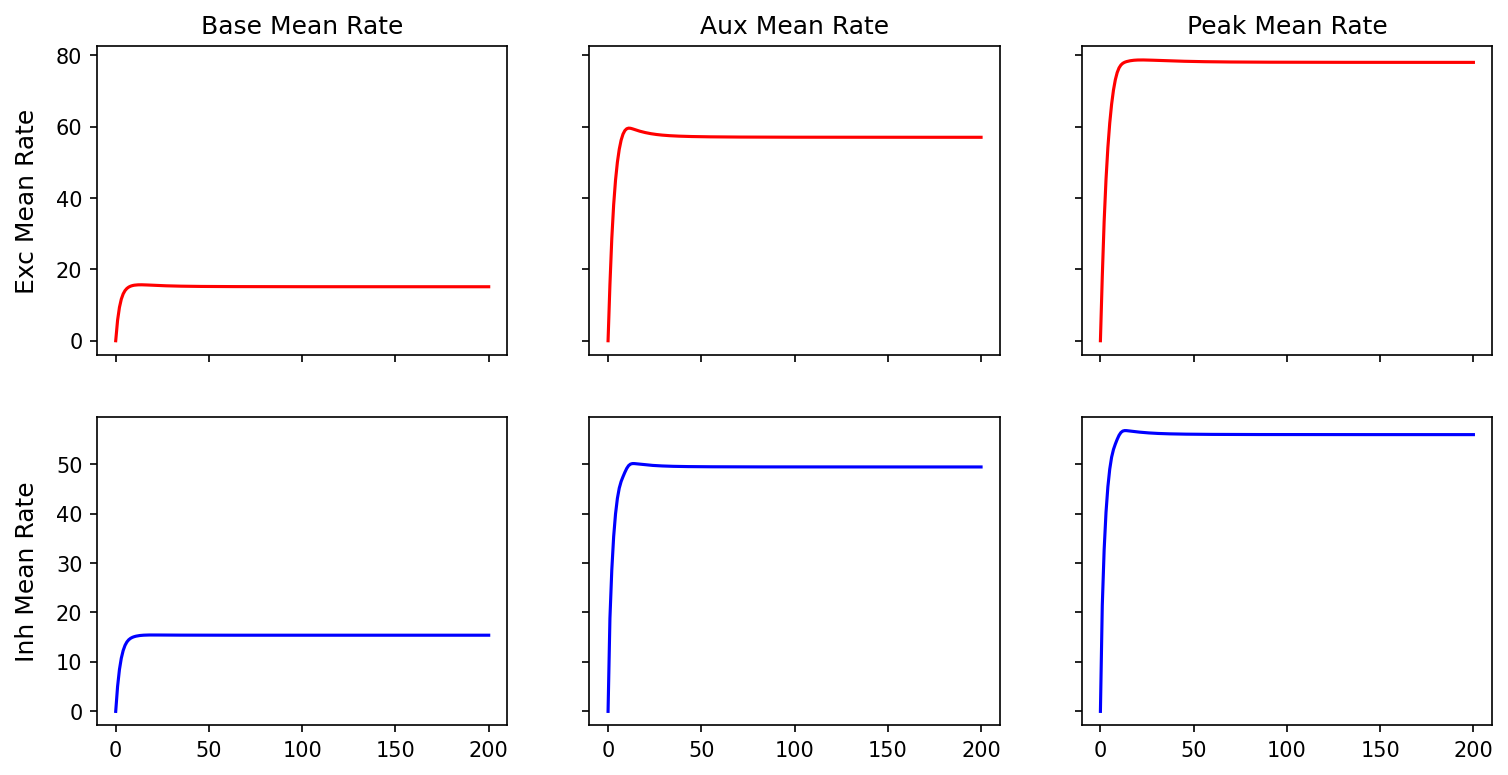

In [347]:
fig,axs = plt.subplots(2,3,figsize=(4*3,3*2),dpi=150,sharex=True,sharey='row')

axs[0,0].plot(full_rb[0],'r')
axs[1,0].plot(full_rb[1],'b')
axs[0,1].plot(full_ra[0],'r')
axs[1,1].plot(full_ra[1],'b')
axs[0,2].plot(full_rp[0],'r')
axs[1,2].plot(full_rp[1],'b')

axs[0,0].set_title('Base Mean Rate')
axs[0,1].set_title('Aux Mean Rate')
axs[0,2].set_title('Peak Mean Rate')

ytitle(axs[0,0],'Exc Mean Rate',xloc=-0.2,fontsize=12)
ytitle(axs[1,0],'Inh Mean Rate',xloc=-0.2,fontsize=12)

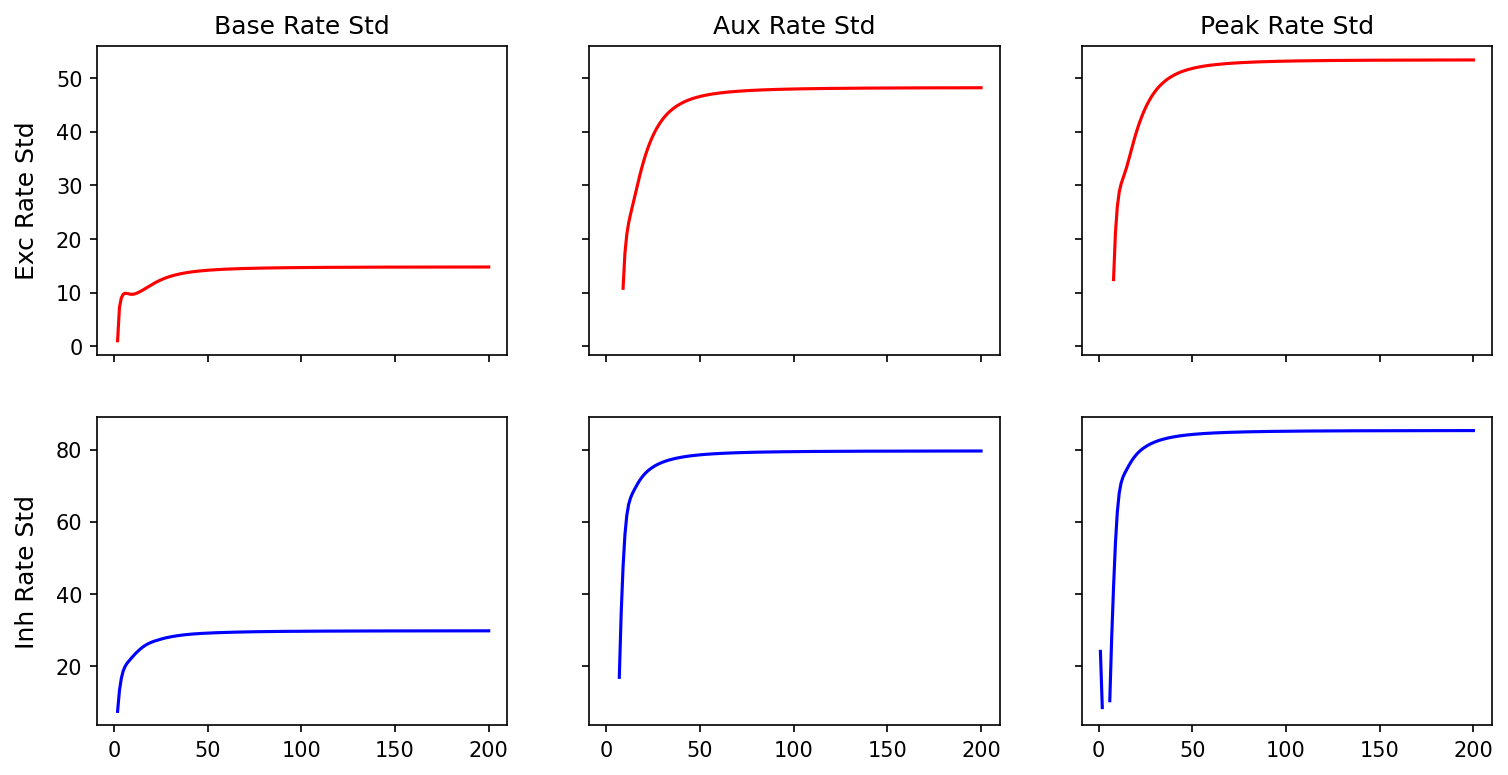

In [350]:
fig,axs = plt.subplots(2,3,figsize=(4*3,3*2),dpi=150,sharex=True,sharey='row')

axs[0,0].plot(np.sqrt(np.diag(full_Crb[0])-rb[0]**2),'r')
axs[1,0].plot(np.sqrt(np.diag(full_Crb[1])-rb[1]**2),'b')
axs[0,1].plot(np.sqrt(np.diag(full_Cra[0])-ra[0]**2),'r')
axs[1,1].plot(np.sqrt(np.diag(full_Cra[1])-ra[1]**2),'b')
axs[0,2].plot(np.sqrt(np.diag(full_Crp[0])-rp[0]**2),'r')
axs[1,2].plot(np.sqrt(np.diag(full_Crp[1])-rp[1]**2),'b')

axs[0,0].set_title('Base Rate Std')
axs[0,1].set_title('Aux Rate Std')
axs[0,2].set_title('Peak Rate Std')

ytitle(axs[0,0],'Exc Rate Std',xloc=-0.2,fontsize=12)
ytitle(axs[1,0],'Inh Rate Std',xloc=-0.2,fontsize=12)

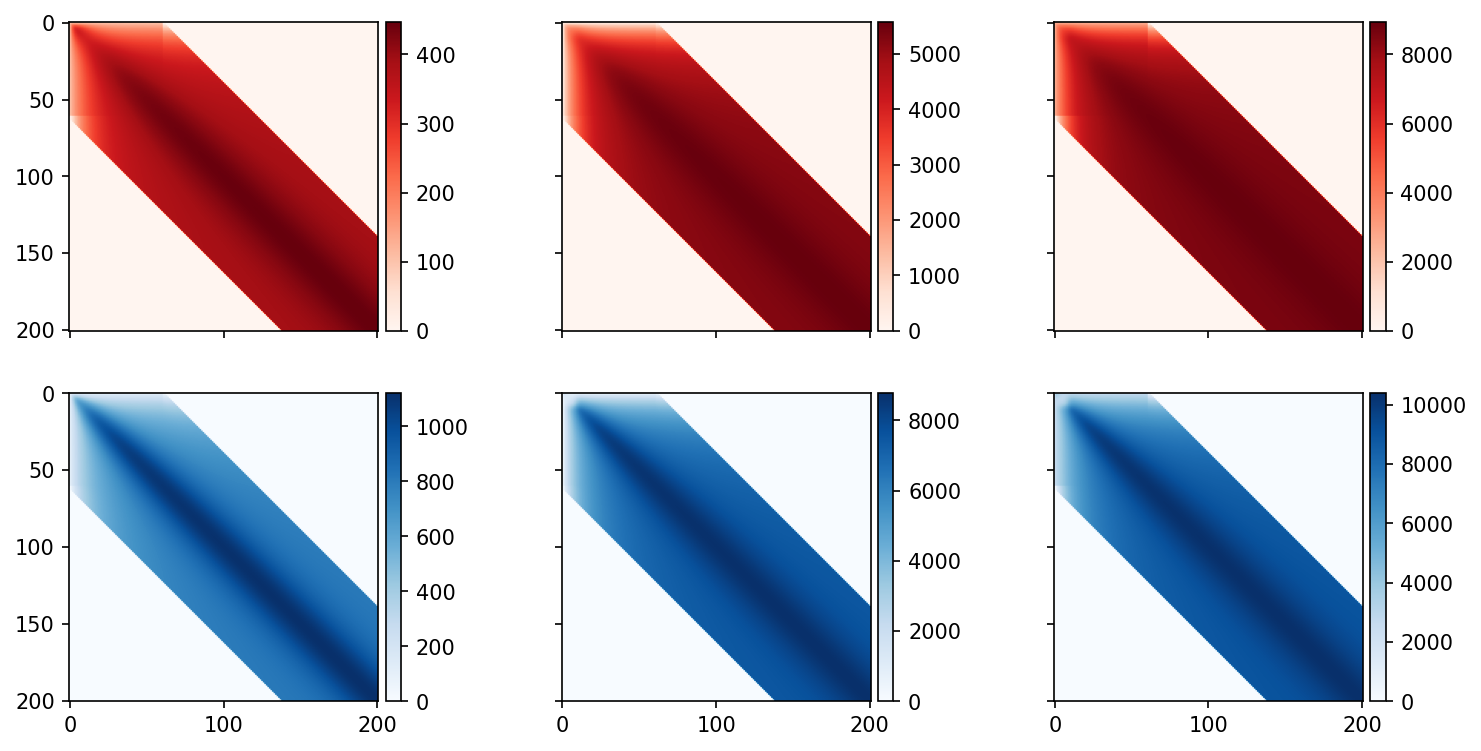

In [359]:
fig,axs = plt.subplots(2,3,figsize=(4*3,3*2),dpi=150,sharex=True,sharey='row')

imshowbar(fig,axs[0,0],full_Crb[0],cmap='Reds')
imshowbar(fig,axs[1,0],full_Crb[1],cmap='Blues')
imshowbar(fig,axs[0,1],full_Cra[0],cmap='Reds')
imshowbar(fig,axs[1,1],full_Cra[1],cmap='Blues')
imshowbar(fig,axs[0,2],full_Crp[0],cmap='Reds')
imshowbar(fig,axs[1,2],full_Crp[1],cmap='Blues')

In [356]:
print(rb)
print(ra)
print(rp)
print(Crb)
print(Cra)
print(Crp)
print(convb)
print(conva)
print(convp)

[15.133963 15.398496]
[57.031326 49.412712]
[78.02973 55.94857]
[[ 447.10297  447.0192   446.77527  446.37372  445.81873  445.11624
   444.2736   443.2995   442.2036   440.99664  439.68976  438.29474
   436.8235   435.28802  433.70023  432.07153  430.41315  428.73553
   427.04865  425.3616   423.683    422.02032  420.3805   418.76962
   417.19293  415.65488  414.15945  412.70972  411.30814  409.9568
   408.65692  407.40952  406.21512  405.07407  403.98587  402.9503
   401.9665   401.03348  400.1503   399.31573  398.5284 ]
 [1123.107   1122.509   1120.7383  1117.8208  1113.7993  1108.7334
  1102.6985  1095.7833  1088.0781  1079.6847  1070.7064  1061.2468
  1051.4098  1041.2935  1030.9929  1020.59515 1010.1806   999.8223
   989.5834   979.5212   969.6823   960.10846  950.8306   941.87573
   933.2625   925.0051   917.11316  909.5897   902.4382   895.6539
   889.2315   883.16626  877.4462   872.0607   866.9996   862.25
   857.7978   853.6296   849.73334  846.0969   842.7056 ]]
[[5577.6953 